#Συμπίεση εικόνων με χρήση FFT

#### Ορισμός συνάρτησης απεικόνισης πολλαπλών εικόνων

In [3]:
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap='gray',vmin=vmin, vmax=vmax)
        ax.set_title(label)

# Βήματα κωδικοποίησης, συμπίεσης και αποκωδικοποίησης εικόνας

Θα δημιουργήσουμε συναρτήσεις για τη υλοποίηση της α) κωδικοποίησης, β) συμπίεσης και γ) αποκωδικοποίησης της εικόνας (Κατεβάστε την εικόνα από [εδώ](https://drive.google.com/file/d/1EzljukzZIIrRO4KeqVI-MFDrhQbjJvvN/view?usp=sharing).



In [5]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import scipy
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2
from scipy.fftpack import dct, idct

from skimage import io,color,img_as_float,img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from numpy import r_
import cv2
#from skimage.draw import line, polygon, circle, ellipse
from PIL import Image 
import math

## Βήμα 1: Κωδικοποίηση εικόνας




### α) Διάβασμα εικόνας και μετατροπή στο χρωματικό χώρο YCbCr

In [6]:
# Read flowers.tif
image=io.imread('flowers.tif')
h=image.shape[0]
w=image.shape[1]
d=image.shape[2]

In [9]:
#RGBtoYCbCrChannel(image)
#input RGB image -> outup Y, Cb, Cr channel , 
#Y:Luminance  Cr = R – Y ( how far is the red component from Luminance)
#Cb = B – Y ( how far is the blue component from Luma ).

def RGBtoYCbCrChannel(image):
   RGB_image = img_as_float(image)
   YCbCr_image =color.rgb2ycbcr(RGB_image)
   YCbCr_image = YCbCr_image.astype(np.uint8)
   #print("type, min, max:", RGB_image.dtype, RGB_image.min(), RGB_image.max())
   print("type, min, max:", YCbCr_image.dtype, YCbCr_image.min(), YCbCr_image.max())
   #YCbCr_image.shape
   Y_channel=img_as_float(YCbCr_image[:,:,0])
   Cb_channel=img_as_float(YCbCr_image[:,:,1])
   Cr_channel=img_as_float(YCbCr_image[:,:,2])

   f, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(1, 5, figsize=(20, 15))
   ax0.imshow(RGB_image)
   ax0.set_title('RGB', fontsize=12)
   ax1.imshow(YCbCr_image)
   ax1.set_title('YCbCr', fontsize=12)
   ax2.imshow(Y_channel)
   ax2.set_title('Y channel', fontsize=12)
   ax3.imshow(Cb_channel)
   ax3.set_title('Cb channel', fontsize=12)
   ax4.imshow(Cr_channel)
   ax4.set_title('Cr channel', fontsize=12)
     
   return Y_channel,Cb_channel,Cr_channel

type, min, max: uint8 16 235


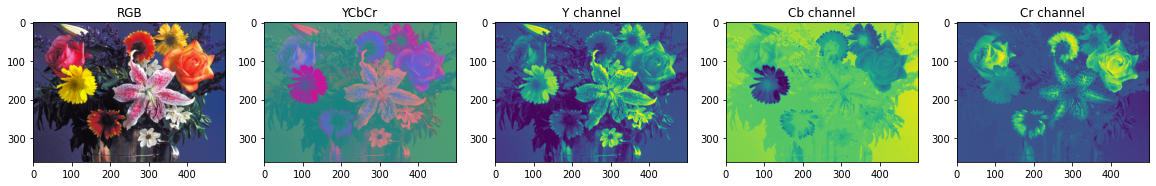

In [8]:
Y_channel,Cb_channel,Cr_channel=RGBtoYCbCrChannel(image)

### β) Χρήση μετασχηματισμού FFT σε ολόκληρη την εικόνα και σε μη επικαλυπτόμενα blocks 8x8 (όμοια όπως στο προηγούμενο εργαστήριο)

In [10]:
def fft2block(a):
  imsize = a.shape
  im_fft = np.zeros(imsize)
  im_fft_shift = np.zeros(imsize)
  # Do 8x8 FFT on image (in-place)
  for i in r_[:imsize[0]:8]:
    for j in r_[:imsize[1]:8]:
        im_fft[i:(i+8),j:(j+8)] = fft2( a[i:(i+8),j:(j+8)])
        im_fft_shift[i:(i+8),j:(j+8)] = fftshift( im_fft[i:(i+8),j:(j+8)])

  return im_fft_shift


def ifft2block(a):
   imsize = a.shape
   im_ifft = np.zeros(imsize)
   # Do 8x8 FFT on image (in-place)
   for i in r_[:imsize[0]:8]:
     for j in r_[:imsize[1]:8]:
       im_ifft[i:(i+8),j:(j+8)] = ifft2(ifftshift( a[i:(i+8),j:(j+8)]))
   return im_ifft




In [11]:
#FFT transform
Y_fft=fft2(Y_channel)
Cb_fft=fft2(Cb_channel)
Cr_fft=fft2(Cr_channel)
#Κεντράρισμα φάσματος
Y_fftsh=fftshift(Y_fft)
Cb_fftsh=fftshift(Cb_fft)
Cr_fftsh=fftshift(Cr_fft)

#--------------------------------

#FFT 8x8 block
Y_fft_blk=fft2block(Y_channel)
Cb_fft_blk=fft2block(Cb_channel)
Cr_fft_blk=fft2block(Cr_channel)

<ipython-input-10-f131eefc0b5f>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  im_fft[i:(i+8),j:(j+8)] = fft2( a[i:(i+8),j:(j+8)])


## Βήμα 2: Συμπίεση εικόνας
### Χρήση κατάλληλης μάσκας για αποκοπή λιγότερων σημαντικών συχνοτήτων

####Μάσκα για αποκοπή λιγότερων σημαντικών στοιχείων του FFT (σε ολόκληρη την εικόνα ή σε block αυτής)

In [12]:
# Δημιουργία ελλειπτικής μάσκας για τον FFT με παραμετροποιημένο μέγεθος 
# nx,ny: ύψος και πλάτος μάσκας (ίδιο με εικόνα για μάσκα στο μέγεθος της εικόνας αλλιώς 8,8 για blocks)
# a,b : για τον ορισμό του μικρού και μεγάλου αξονα της έλλειψης τιμές : 1-5


def create_ellipse_mask(nx,ny,a,b): # a, b ellipse's lengths
   # set up a coordinate system    
  x = np.linspace(-5.0, 5.0, max(nx,ny))   #x=-5....elements oflinear space=max(nx,ny)..5
  y = np.linspace(-5.0, 5.0, max(nx,ny))
  # Setup arrays which just list the x and y coordinates
  xgrid, ygrid = np.meshgrid(x, y) 
  # Calculate the ellipse values all at once
  ellipse = xgrid**2 / a**2 + ygrid**2 / b**2
  # Create an array of int32 zeros
  grey = np.zeros((max(nx,ny),max(nx,ny)), dtype=np.int32)
  # Put 1's where ellipse is less than 1.0
  # Note ellipse <1.0 produces a boolean array that then indexes grey
  grey[ellipse < 1.0] = 1
  mask=np.zeros((nx,ny), dtype=np.int32)
  if (nx<ny):
    offset=math.trunc(np.round_((ny-nx)/2))
    mask = grey[offset:ny-offset, 0:ny]
  elif(nx>ny):
    offset=math.trunc(np.round_((nx-ny)/2))
    mask = grey[0:nx, offset:nx-offset]
  else:
    mask=grey
  return mask

### Εφαρμογή μασκών

#### α) Εφαρμογή μάσκας για αποκοπή λιγότερων σημαντικών στοιχείων του FFT (σε ολόκληρη την εικόνα)

In [13]:
maskY=create_ellipse_mask(Y_channel.shape[0],Y_channel.shape[1],3,2)
Y_fftsh_mask=Y_fftsh*maskY

maskCb=create_ellipse_mask(Cb_channel.shape[0],Cb_channel.shape[1],1,1)
Cb_fftsh_mask=Cb_fftsh*maskCb

maskCr=create_ellipse_mask(Cr_channel.shape[0],Cr_channel.shape[1],1,1)
Cr_fftsh_mask=Cr_fftsh*maskCr
 

Text(0.5, 1.0, 'Cb Channel after applying mask')

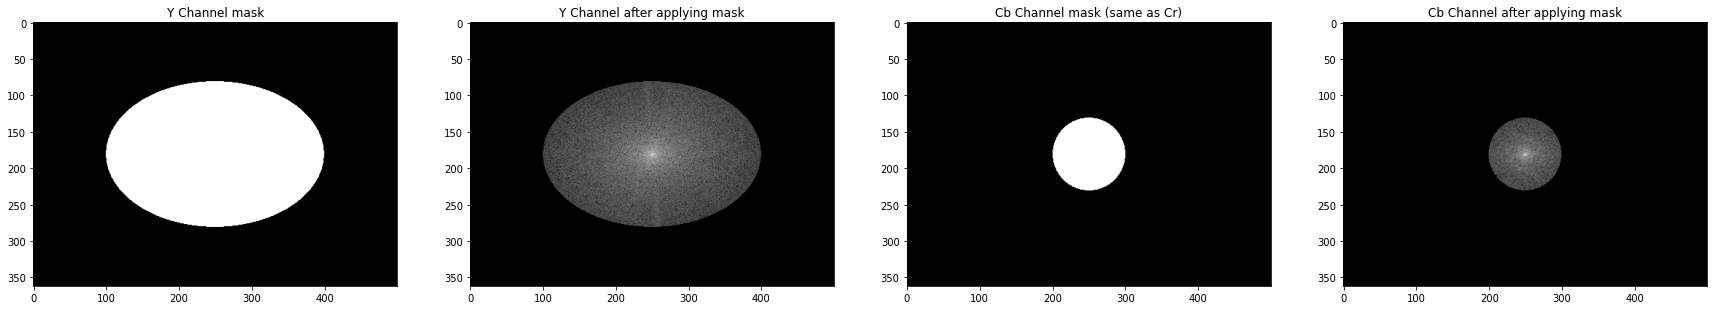

In [14]:
f, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(30, 20))

ax0.imshow(maskY,cmap='gray')
ax0.set_title('Y Channel mask', fontsize=12)

ax1.imshow(np.log10(1+abs(Y_fftsh_mask)), cmap='gray')
ax1.set_title('Y Channel after applying mask', fontsize=12)

ax2.imshow(maskCb,cmap='gray')
ax2.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax3.imshow(np.log10(1+abs(Cb_fftsh_mask)), cmap='gray')
ax3.set_title('Cb Channel after applying mask', fontsize=12)

#### b) Εφαρμογή μάσκας για αποκοπή λιγότερων σημαντικών στοιχείων του FFT (σε block 8x8 την εικόνα)

In [15]:
maskblkfft=create_ellipse_mask(8,8,4,3)
maskblkfftY = cv2.filter2D(Y_fft_blk,-1,maskblkfft)
maskblkfft=create_ellipse_mask(8,8,1,1)
maskblkfftCb = cv2.filter2D(Cb_fft_blk,-1,maskblkfft)
maskblkfft=create_ellipse_mask(8,8,1,1)
maskblkfftCr = cv2.filter2D(Cr_fft_blk,-1,maskblkfft)

Text(0.5, 1.0, 'Cb Channel after applying mask')

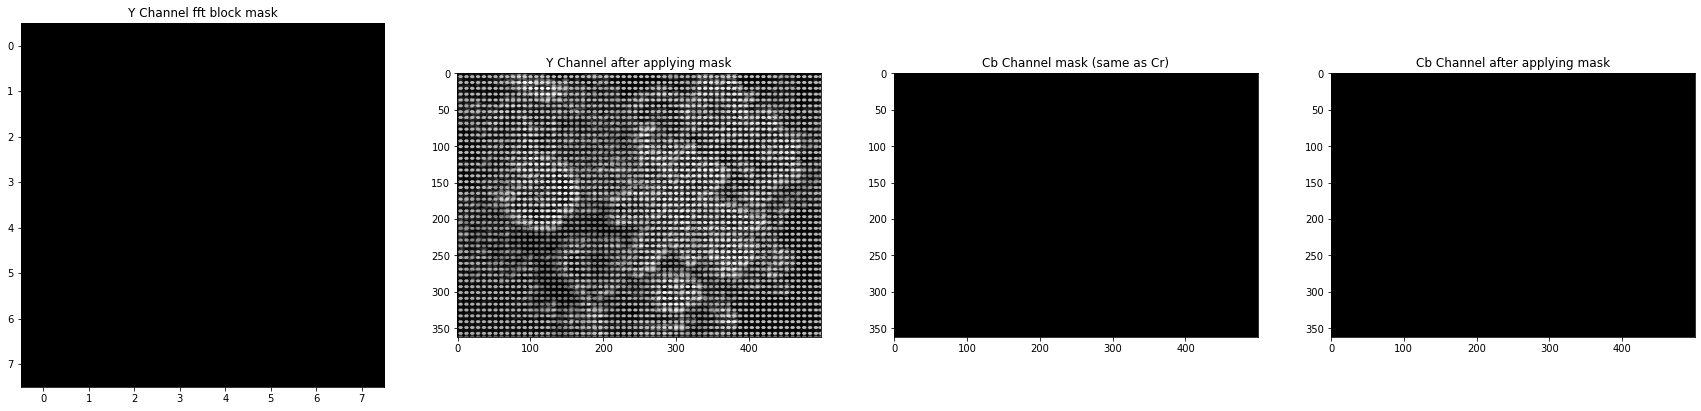

In [16]:
f, (ax0,ax1,ax2,ax3) = plt.subplots(1, 4, figsize=(30, 20))

ax0.imshow(maskblkfft,cmap='gray')
ax0.set_title('Y Channel fft block mask', fontsize=12)

ax1.imshow(np.log10(1+abs(maskblkfftY)), cmap='gray')
ax1.set_title('Y Channel after applying mask', fontsize=12)

ax2.imshow(np.log10(1+abs(maskblkfftCr)),cmap='gray')
ax2.set_title('Cb Channel mask (same as Cr)', fontsize=12)

ax3.imshow(np.log10(1+abs(maskblkfftCb)), cmap='gray')
ax3.set_title('Cb Channel after applying mask', fontsize=12)

##Βήμα 3: Αποκωδικοποίηση εικόνας



####Αντίστροφος μετασχηματισμό FFT για την εικόνα που εφαρμόσαμε συμπίεση με μάσκα για FFT ίδιου μεγέθους με τη αρχική εικόνα

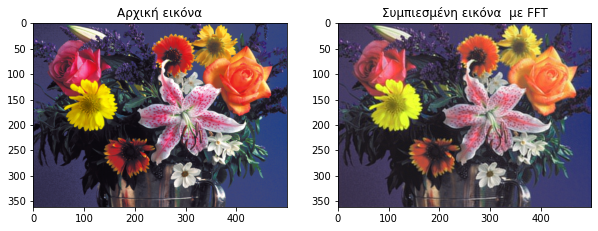

In [17]:
ifftYCbCr=np.zeros(image.shape) # initial image

ifftYCbCr[:,:,0]=abs(ifft2(ifftshift(Y_fftsh_mask)))
ifftYCbCr[:,:,1]=abs(ifft2(ifftshift(Cb_fftsh_mask)))
ifftYCbCr[:,:,2]=abs(ifft2(ifftshift(Cr_fftsh_mask)))

ifftYCbCr = ifftYCbCr.astype('float32')

ifftRGB = cv2.cvtColor(ifftYCbCr, cv2.COLOR_YCrCb2BGR)

#Απεικόνιση και αποθήκευση της συμπιεσμένης εικόνας
imshow_all(image,ifftRGB, titles= ['Αρχική εικόνα','Συμπιεσμένη εικόνα  με FFT'])
io.imsave('FFTcompressed.bmp', ifftRGB)

####Αντίστροφος μετασχηματισμό FFT για την εικόνα που εφαρμόσαμε συμπίεση με μάσκα 8x8 σε FFT block

<ipython-input-10-f131eefc0b5f>:20: ComplexWarning: Casting complex values to real discards the imaginary part
  im_ifft[i:(i+8),j:(j+8)] = ifft2(ifftshift( a[i:(i+8),j:(j+8)]))


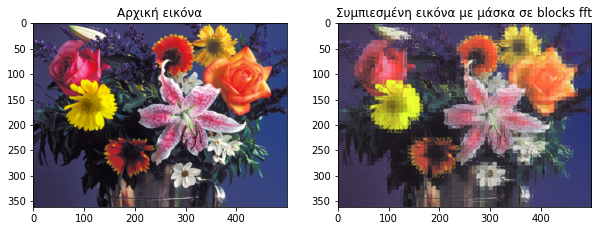

In [18]:
im_ifftblk = np.zeros(image.shape)

im_ifftblk[:,:,0]=ifft2block(Y_fft_blk)
im_ifftblk[:,:,1]=ifft2block(Cb_fft_blk)
im_ifftblk[:,:,2]=ifft2block(Cr_fft_blk)

im_ifftblk = im_ifftblk.astype('float32')
iblkfftRGB = cv2.cvtColor(im_ifftblk, cv2.COLOR_YCrCb2BGR)
iblkfftRGB =np.real(iblkfftRGB)

imshow_all(image,iblkfftRGB, titles= ['Αρχική εικόνα','Συμπιεσμένη εικόνα με μάσκα σε blocks fft'])
io.imsave('blkfft.bmp', iblkfftRGB)

####Peak to Signal Noise Ratio-PSNR
To PSNR εκφράζει τη διαφορά σήματος μεταξύ της μέγιστης δυνατής τιμής του σήματος και την δύναμη παραμόρφωσης του σήματος που επηρεάζει την ποιότητά του. Όταν χρησιμοποιούμε τον PSNR για εκτίμηση ποιότητας της εικόνας σαν σήμα ορίζουμε τα αρχικά δεδομένα μας (την αρχική εικόνα μας) και η παραμόρφωση είναι ουσιαστικά ο θόρυβος που εισάγεται κατά τη συμπίεση της εικόνας μας.

Ο αλγόριθμος PSNR για να κάνει εκτίμηση της ποιότητας της εικόναςχρησιμοποιεί
το MSE (mean square error). Ο MSE εκφράζει τη μέση τετραγωνική τιμή μεταξύ
της αρχικής  (I) και της παραμορφωμένης (I') εικόνας. 

$$MSE=\frac{1}{m,n}\sum _{i=0}^{m-1}\sum _{j=0}^{n-1}[I(i,j)-Ι'(i,j)]^{2}$$

To PSNR (σε dB) ορίζεται ως
$$PSNR=10 \cdot log_{10}\frac{MAX_I^2}{MSE}=20 \cdot log_{10}\frac{MAX_I}{\sqrt{MSE}}=20 \cdot log_{10}{MAX_I}-10\cdot log_{10}{MSE}$$

Το εύρος τιμών κυμαίνεται από 0 έως 100 dB και τιμές μεταξύ 20 έως 40 dB θεωρούνται αποδεκτές ενώ τιμές γύρω από το 100 δίνουν μέγιστες παραμορφώσεις.

In [19]:
def psnr(original, compressed):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR




In [20]:
    snrfft=compute_psnr(ifftRGB,image)
    snrfftblk=compute_psnr(iblkfftRGB,image)
    
    print('SNR FFT σε ολόκληρη την εικόνα:',snrfft)
    print('SNR FFT σε block 8x8 την εικόνα:',snrfftblk)    

NameError: ignored

### Λόγος συμπίεσης
$$Compression Ration=CR=\frac{SIZE_{UncompressedImage}}{SIZE_{CompressedImage}}$$

*Παράδειγμα*
> Έστω η Original Image έχει μέγεθος (256x256)pixels x 8 bits per pixel τότε θα είναι:
 $SIZE_{UncompressedImage}$= 65536 bytes

 >Έστω μια συμπίεση της Original Image έχει μέγεθος  $SIZE_{CompressedImage}$= 6554 bytes

 τότε το $CR$=9,999=10 ή $CR$ 10:1


##Bits per pixels

Για μία εικόνα MxM έχουμε:
$$\frac{bits}{pixels}=\frac{N_{bits}}{N_{pixels}}=\frac{8(N_{bytes})}{MxM}$$

In [21]:
 
CRfft=sum(sum((Y_fftsh_mask != 0) + (Cb_fftsh_mask != 0) + (Cr_fftsh_mask != 0))) / (image.shape[0]*image.shape[1]*image.shape[2]);

print('Compression Ration μετά από συμπίεση με FFT σε ολόκληρη την εικόνα:',CRfft)


Compression Ration μετά από συμπίεση με FFT σε ολόκληρη την εικόνα: 0.08640147329650093
